In [326]:
import pandas as pd
import numpy as np
import os
from pypfopt import EfficientFrontier
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [327]:
os.chdir('./src')
import algorithm as al
os.chdir('../')

In [328]:
# read regime
regime = pd.read_pickle('./data/regime/regime.pkl')

# read pool
pool = pd.read_pickle('./data/regime/pool_df.pkl')

# read stock data
stocks = pd.read_pickle('./data/regime/all_stocks.pkl')

# read spy data
spy = pd.read_pickle('./data/stocks/spy.pkl')

In [329]:
regime.head(10)

,state
Date,
2018-01-02,bull1
2018-01-03,bull1
2018-01-04,bull1
2018-01-05,bull1
2018-01-08,bull1
2018-01-09,bull1
2018-01-10,bull1
2018-01-11,bull1
2018-01-12,bull2


In [330]:
pool.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,1,1,1,1,1,1,1,0,1,...,0,0,1,0,1,1,1,1,0,1
2018-01-03,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,0,1
2018-01-04,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,1,1,1,1,0,1
2018-01-05,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,1,1,1,1,1,1
2018-01-08,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1


In [311]:
stocks.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-01 00:00:00,24.830606,28.697052,31.488310,4.116690,18.598913,10.28,17.197018,31.246460,39.580002,24.591806,...,74.684135,15.559514,57.119190,11.895068,49.974968,33.670444,16.927359,70.522545,36.410000,59.761684
2007-08-02 00:00:00,25.129925,28.942163,32.129063,4.162127,18.502197,10.98,17.284765,31.735386,39.520000,24.815556,...,74.443825,15.277222,59.724373,11.923719,49.590725,33.507782,17.109375,69.866684,36.619999,59.745808
2007-08-03 00:00:00,24.713476,29.356966,30.820082,4.020632,18.574739,10.46,17.244265,30.840256,38.750000,24.042610,...,72.650673,14.803766,59.565212,11.345008,47.785950,33.607197,16.756052,68.333405,36.520000,57.183327
2007-08-06 00:00:00,24.928205,28.282246,31.149612,4.124312,19.211496,10.99,17.929445,31.374329,39.380001,24.849463,...,75.035393,15.081611,63.296146,11.786206,48.635948,34.348202,17.168262,69.263992,36.000000,60.974262
2007-08-07 00:00:00,24.921705,29.479525,30.957394,4.117606,18.433691,11.72,18.327732,31.562370,39.419998,24.903702,...,73.537979,15.194982,69.667603,12.026857,49.893486,34.230724,17.087955,69.919868,36.000000,61.453125


In [25]:
# a simple strategy
def strategy(states):
    tail15 = states.tail(15)
    tail7 = states.tail(7)
#     print(tail7)
    c15_count = int(tail15[tail15=='cris'].count())
    b15_count = int(tail15[tail15=='bear'].count())
    c7_count = int(tail7[tail7=='cris'].count())
    b7_count = int(tail7[tail7=='bear'].count())
    bull_count = int(tail7[tail7=='bull1'].count()) + int(tail7[tail7=='bull2'].count())
    if c7_count > 0 or c15_count > 3:
        return -2
    elif b7_count > 0 or b15_count > 3:
        return -1
    elif bull_count > 7:
        return 1
    else:
        return 0

In [26]:
stock_list = list(stocks.columns.to_list())
def process_weights(w, stock_list):
    s = list(w.keys())
    missing = [x for x in stocks if x not in s]
    missing_w = {key: 0 for key in missing}
    return w|missing_w

In [29]:
date = regime.index.to_list()
init_w ={key: 0 for key in stock_list}
position = pd.DataFrame(init_w, index=date)
prev_strategy = 0

failed_date = []

for d in tqdm(date):
    curr_state = regime[regime.index <= d]
    curr_strategy = strategy(curr_state)
#     print(curr_strategy)
    # optimization model
    
    # strategy decision
    if curr_strategy == 1 or prev_strategy <= 0:
        try:
            mu,S = al.estimate(stocks, pool, d, 360)
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
            raw_weights = ef.max_sharpe()
            w = ef.clean_weights()
        except:
            failed_date.append(d)
        prev_strategy += 1
    elif curr_strategy == 1 and prev_strategy >= 30:
        try:
            mu,S = al.estimate(stocks, pool, d, 360)
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
            raw_weights = ef.max_sharpe()
            w = ef.clean_weights()
        except:
            failed_date.append(d)
        prev_strategy = 1
    elif curr_strategy == -1:
#         print(-1)
        try:
            mu,S = al.estimate(stocks, pool, d, 360)
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
            raw_weights = ef.max_quadratic_utility()
            w = ef.clean_weights()
        except:
            failed_date.append(d)
        prev_strategy = -1
    elif curr_strategy == -2:
#         print(-2)
        w = init_w
        prev_strategy = -2
    else:
        pass
    w = process_weights(w, stock_list)
    position.loc[d, :] = w

  0%|                                                          | 0/1173 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
  1%|▌                                                | 13/1173 [00:05<09:42,  1.99it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
  1%|▋                                                | 16/1173 [00:07<12:20,  1.56it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for mor

 38%|██████████████████▎                             | 448/1173 [02:02<04:18,  2.81it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 39%|██████████████████▋                             | 458/1173 [02:06<04:18,  2.77it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 39%|██████████████████▉                             | 462/1173 [02:08<05:55,  2.00it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for mor

 55%|██████████████████████████▍                     | 647/1173 [03:16<07:09,  1.22it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 57%|███████████████████████████▏                    | 664/1173 [03:32<08:13,  1.03it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 58%|███████████████████████████▌                    | 675/1173 [03:34<01:57,  4.25it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for mor

 62%|█████████████████████████████▉                  | 731/1173 [04:09<06:46,  1.09it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 63%|██████████████████████████████                  | 735/1173 [04:12<06:52,  1.06it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 63%|██████████████████████████████▍                 | 744/1173 [04:16<03:48,  1.88it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for mor

 69%|████████████████████████████████▉               | 805/1173 [04:55<04:04,  1.51it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 69%|████████████████████████████████▉               | 806/1173 [04:56<04:44,  1.29it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 69%|█████████████████████████████████               | 808/1173 [04:57<04:06,  1.48it/s]/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for mor

In [33]:
position.to_pickle('./data/regime/postion.pkl')

In [34]:
failed_date.to_pickle('./data/regime/failed.pkl')

AttributeError: 'list' object has no attribute 'to_pickle'

In [331]:
position

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2018-01-03,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-04,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-05,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-08,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-09,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2022-08-24,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2022-08-25,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2022-08-26,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [332]:
# calculate returns
returns = stocks[stocks.index>=pd.to_datetime('2018-01-02')]
returns = np.log(returns/returns.shift(1))
returns = returns.dropna()

In [333]:
spy = spy[spy.index>=pd.to_datetime('2018-01-02')]
spy = spy.loc[:, 'Adj Close']
spy = np.log(spy/spy.shift(1))
spy = spy.dropna()
spy

Date
2018-01-03    0.006305
2018-01-04    0.004206
2018-01-05    0.006642
2018-01-08    0.001827
2018-01-09    0.002261
                ...   
2022-08-23   -0.002422
2022-08-24    0.003196
2022-08-25    0.014019
2022-08-26   -0.034435
2022-08-29   -0.006634
Name: Adj Close, Length: 1172, dtype: float64

In [334]:
position = position[position.index>=pd.to_datetime('2018-01-03')]
position

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2018-01-03,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-04,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-05,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-08,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2018-01-09,0,0.0,0.0,0.01198,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2022-08-24,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2022-08-25,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2022-08-26,0,0.0,0.0,0.00000,0,0.0,0.0,0,0.0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [335]:
position1 = position.copy(deep=True)

In [336]:
tmp = position1.sum(axis=1)
tmp = tmp[tmp>1] - 1
position1.loc[tmp.index,'AAPL'] -= tmp

In [337]:
position2 = pd.DataFrame([],index = position.index, columns=position.columns)
position2.iloc[:,:] = 1/426
position2

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
2018-01-03,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-04,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-05,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-08,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2018-01-09,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-23,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2022-08-24,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2022-08-25,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347
2022-08-26,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,...,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347,0.002347


In [338]:
turnover = abs(position1 - position1.shift(1)).dropna()
turnover = turnover.sum(axis=1)
turnover

2018-01-04    0.00000
2018-01-05    0.00000
2018-01-08    0.00000
2018-01-09    0.00000
2018-01-10    0.00000
               ...   
2022-08-23    0.19984
2022-08-24    1.00000
2022-08-25    0.99999
2022-08-26    0.21070
2022-08-29    0.17157
Length: 1171, dtype: float64

In [339]:
turnover.sum()

716.8987400000001

In [340]:
pnl = np.multiply(returns,position1).sum(axis=1)

In [341]:
pnl2 = np.multiply(returns,position2).sum(axis=1)

In [342]:
pnl = pnl.cumsum() - turnover*0.03
spy = spy.cumsum()
pnl2 = pnl2.cumsum()

In [343]:
# date1 = pd.to_datetime('2018-1-1')
# date2 = pd.to_datetime('2018-3-1')
# pnl = pnl[(pnl.index>date1) & (pnl.index<date2)]
# pnl2 = pnl2[(pnl2.index>date1) & (pnl2.index<date2)]
# spy = spy[(spy.index>date1) & (spy.index<date2)]

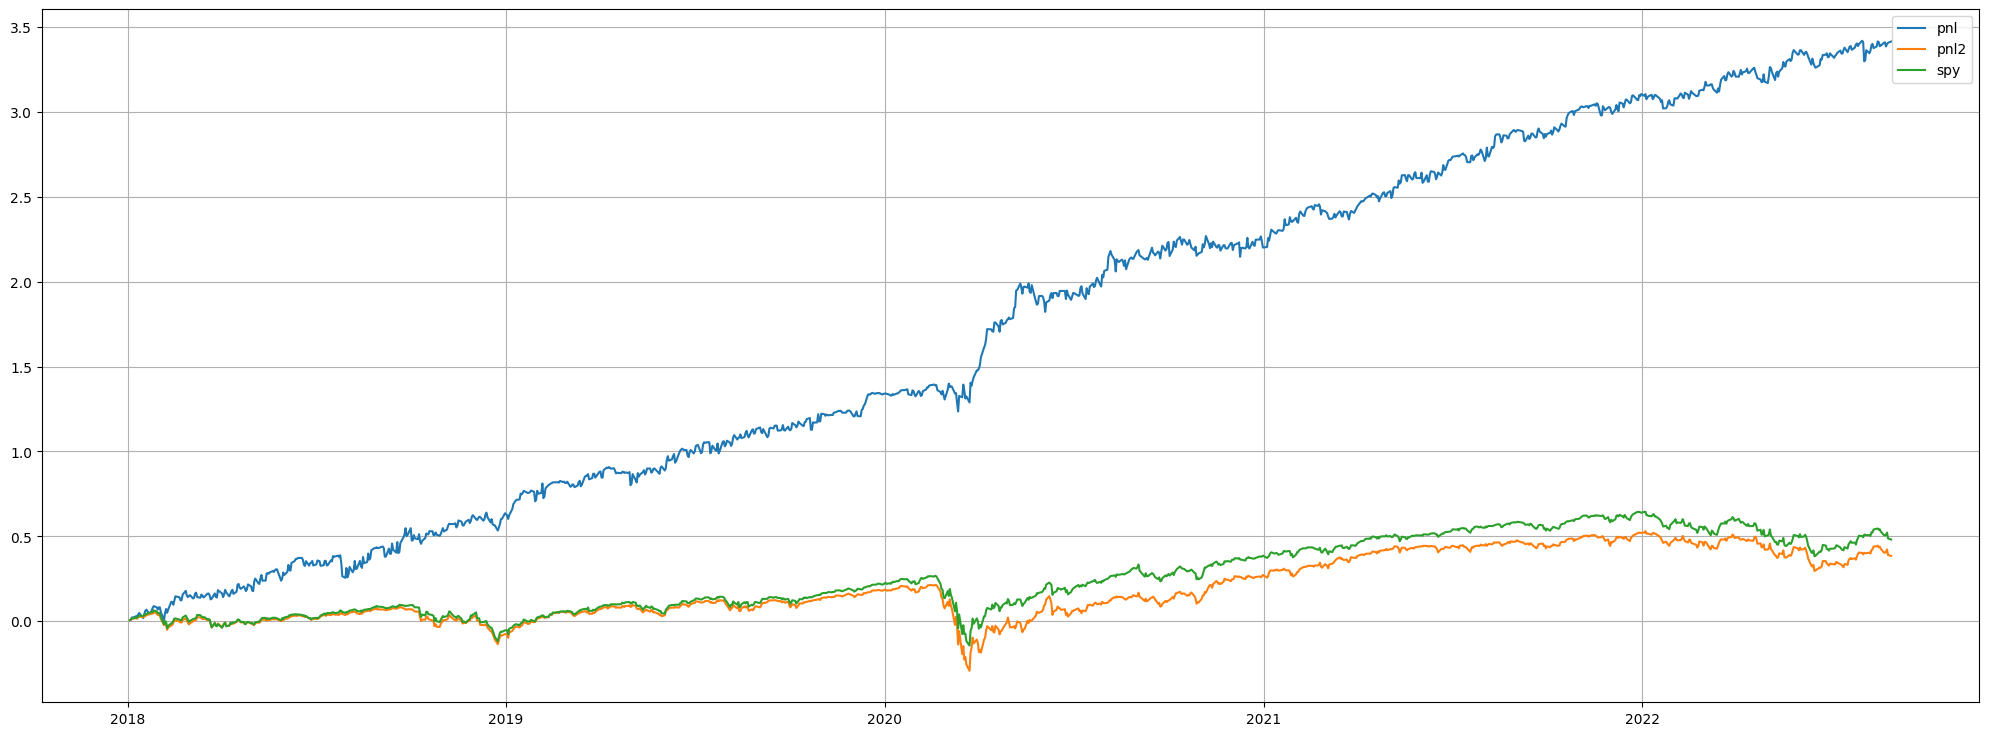

In [344]:
fig = plt.figure(figsize=(25,9))
colors = sns.color_palette("muted", 3)
plt.plot(pnl, label='pnl')
plt.plot(pnl2, label = 'pnl2')
plt.plot(spy, label='spy')
plt.grid()
plt.legend()
plt.show()